# Mean and Patch PCA

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.time import Time
from astropy.constants import c
from scipy import interpolate
from scipy.optimize import minimize, least_squares, curve_fit
from mpfit import mpfit

from tqdm import tqdm
import seaborn as sns

from waveCal import *

In [2]:
# Gather files
lfc_files = glob('/mnt/home/lzhao/ceph/lfc5a/LFC_*.fits')
num_files = len(lfc_files)
print(f'Number of files: {num_files}')

hdus = fits.open(lfc_files[0])
t_spec = hdus[1].data['spectrum'].copy()
t_errs = hdus[1].data['uncertainty'].copy()
t_mask = hdus[1].data['pixel_mask'].copy()
hdus.close()
nord, npix = t_spec.shape

lfc_orders = range(41,76)

Number of files: 689


In [3]:
# LFC line fit files
ckpt_files  = glob('/mnt/home/lzhao/ceph/ckpt5a/LFC_19*.npy')

In [4]:
# Sort files by date:
file_times = np.empty_like(ckpt_files,dtype='float')
for i in range(len(ckpt_files)):
    file_times[i] = os.path.basename(ckpt_files[i]).split('_')[-1][:-4]
ckpt_files = np.array(ckpt_files)[np.argsort(file_times)]

file_times = np.empty_like(lfc_files,dtype='float')
for i in range(len(lfc_files)):
    file_times[i] = os.path.basename(lfc_files[i]).split('_')[-1][:-5]
lfc_files = np.array(lfc_files)[np.argsort(file_times)]

In [5]:
# Load in all observed modes into a big dictionary
rep_rate = 14e9 # magic
lfc_offset = 6.19e9 # magic
order_list = range(45,75)
# mode, wavelength, x, m
modedict = {}
for file_name in ckpt_files:
    try:
        x,m,e,w = readParams(file_name)
    except ValueError:
        continue
    for nord in order_list:
        n = np.round((1/(w[m==nord]/1e10)*c.value-lfc_offset)/rep_rate)
        if nord not in modedict.keys():
            modedict[nord] = np.array([])
        modedict[nord] = np.unique(np.concatenate([modedict[nord].astype(int),n.astype(int)]))

In [6]:
# Reformat mode dictionary into a flat vector
modes = np.array([]).astype(int)
orders = np.array([]).astype(int)
for m in modedict.keys():
    modes = np.concatenate((modes, modedict[m]))
    orders = np.concatenate((orders, (np.zeros_like(modedict[m])+m)))

In [7]:
# True Wavelengths
freq = modes * rep_rate + lfc_offset  # true wavelength
waves = c.value / freq * 1e10 # magic

In [8]:
# Load in x values to match order/mode lines
x_values = np.empty((len(ckpt_files),len(modes)))
x_values[:] = np.nan
for i in tqdm(range(len(ckpt_files))):
    file_name = ckpt_files[i]
    try:
        x,m,e,w = readParams(file_name)
    except ValueError:
        continue
    for line in range(len(modes)):
        I = m==orders[line]
        if waves[line] in w[I]:
            x_values[i,line] = x[I][w[I]==waves[line]] # hogg hates this line
        else:
            x_values[i,line] = np.nan

100%|██████████| 689/689 [04:53<00:00,  2.20it/s]


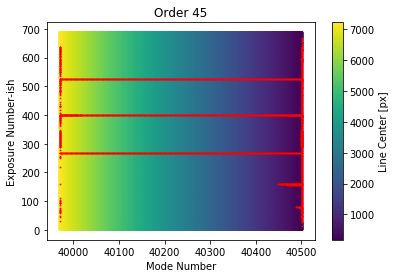

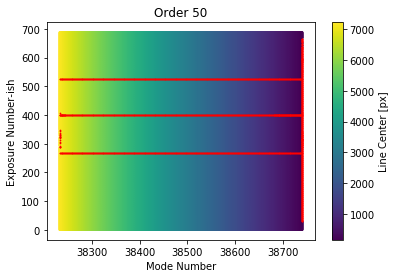

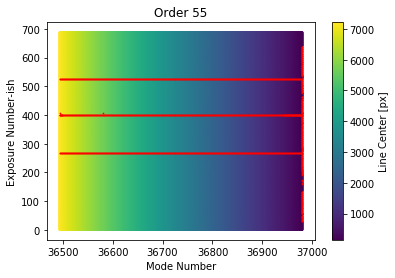

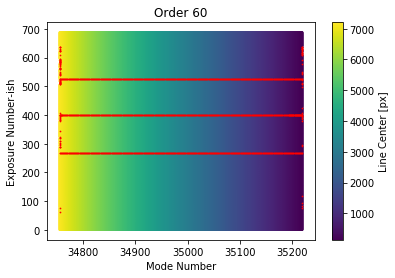

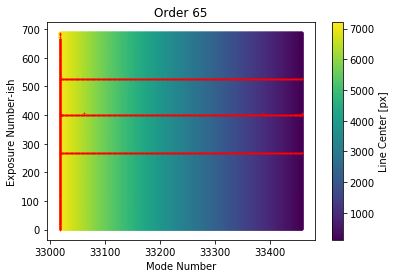

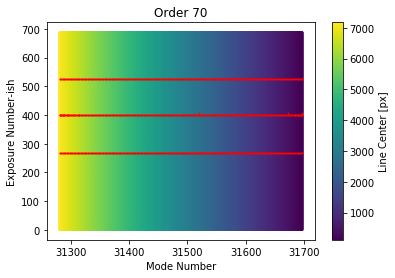

In [9]:
# Where are we missing lines?
for m in order_list[::5]:
    ord_mask = orders==m
    x_range = modes[ord_mask]
    e_range = np.arange(len(ckpt_files)).astype(float)
    x_grid, e_grid = np.meshgrid(x_range,e_range)

    plt.figure()
    plt.title(f'Order {m}')
    plt.scatter(x_grid,e_grid,c=x_values[:,ord_mask],s=1)
    plt.colorbar(label='Line Center [px]')
    nan_mask = np.isnan(x_values[:,ord_mask])
    plt.scatter(x_grid[nan_mask],e_grid[nan_mask],s=.5,c='r')
    plt.xlabel('Mode Number')
    plt.ylabel('Exposure Number-ish');

Text(0.5, 0, 'Mode Number')

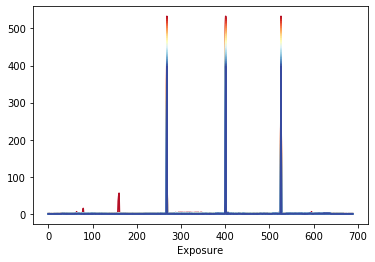

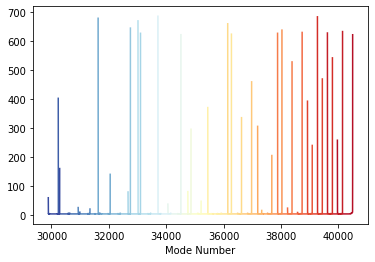

In [10]:
colors = sns.color_palette('RdYlBu',len(order_list))

plt.figure()
for i,nord in enumerate(order_list):
    plt.plot(np.sum(np.isnan(x_values[:,orders==nord]),axis=1),color=colors[i])
plt.xlabel('Exposure')

plt.figure()
for i,nord in enumerate(order_list):
    plt.plot(modes[orders==nord],
             np.sum(np.isnan(x_values[:,orders==nord]),axis=0),color=colors[i])
plt.xlabel('Mode Number')

In [11]:
# Get rid of bad modes
x_values[x_values < 1] = np.nan
good_lines = np.mean(np.isnan(x_values),axis=0) < 0.5

# Trim everything
modes  = modes[good_lines]
orders = orders[good_lines]
waves  = waves[good_lines]
x_values = x_values[:,good_lines]

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [12]:
np.sum(np.isnan(x_values))

46211

In [13]:
# Get rid of bad exposures
good_exps = np.mean(np.isnan(x_values),axis=1) < 0.5
print(ckpt_files[~good_exps])

# Trim everything
x_values = x_values[good_exps]
exp_list = ckpt_files[good_exps]

bad_mask = np.isnan(x_values)
print(modes.shape, exp_list.shape, x_values.shape, bad_mask.shape)

['/mnt/home/lzhao/ceph/ckpt5a/LFC_190821.1094.npy'
 '/mnt/home/lzhao/ceph/ckpt5a/LFC_190824.1281.npy'
 '/mnt/home/lzhao/ceph/ckpt5a/LFC_190825.1141.npy']
(13956,) (686,) (686, 13956) (686, 13956)


In [14]:
np.sum(np.isnan(x_values))

4343

Text(0.5, 0, 'Mode Number')

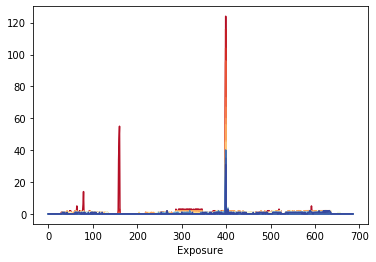

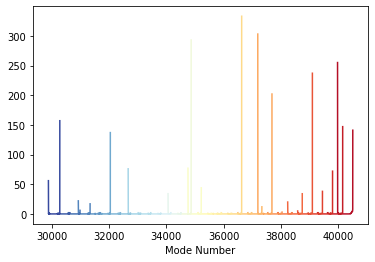

In [15]:
colors = sns.color_palette('RdYlBu',len(order_list))

plt.figure()
for i,nord in enumerate(order_list):
    plt.plot(np.sum(np.isnan(x_values[:,orders==nord]),axis=1),color=colors[i])
plt.xlabel('Exposure')

plt.figure()
for i,nord in enumerate(order_list):
    plt.plot(modes[orders==nord],
             np.sum(np.isnan(x_values[:,orders==nord]),axis=0),color=colors[i])
plt.xlabel('Mode Number')

In [16]:
# Patch bad data with running mean
half_size = 4
for i in range(x_values.shape[0]):
    exp_range = [max((i-half_size,0)), min((i+half_size+1,x_values.shape[1]))]
    run_med = np.nanmean(x_values[exp_range[0]:exp_range[1],:],axis=0)
    x_values[i][bad_mask[i,:]] = run_med[bad_mask[i,:]]

In [17]:
# Iterative PCA
num_iters = 16

iter_x_values = np.zeros((num_iters,*x_values.shape))
iter_vvs = np.zeros((num_iters,*x_values.shape))

for i in tqdm(range(num_iters)):
    mean_x_values = np.mean(x_values,axis=0)
    uu,ss,vv = np.linalg.svd(x_values-mean_x_values,full_matrices=False)
    iter_vvs[i] = vv.copy()

    # Repatch bad data with K=2 PCA reconstruction
    pca_patch = np.dot((uu*ss)[:,0:2],vv[0:2])
    x_values[bad_mask] = (pca_patch+mean_x_values)[bad_mask]
    iter_x_values[i] = x_values.copy()

100%|██████████| 16/16 [00:49<00:00,  3.13s/it]


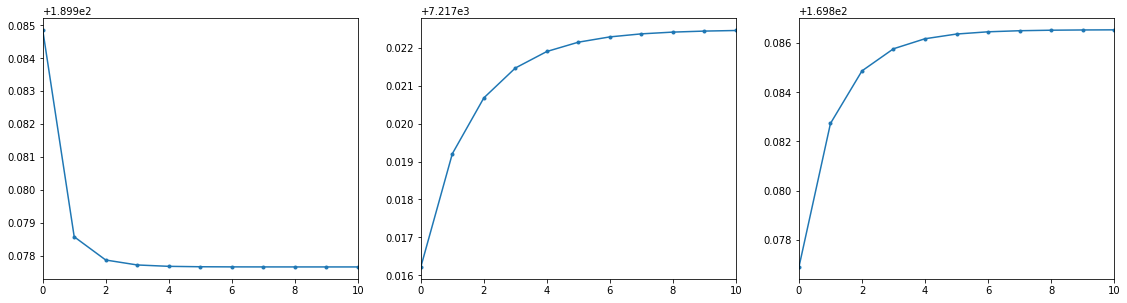

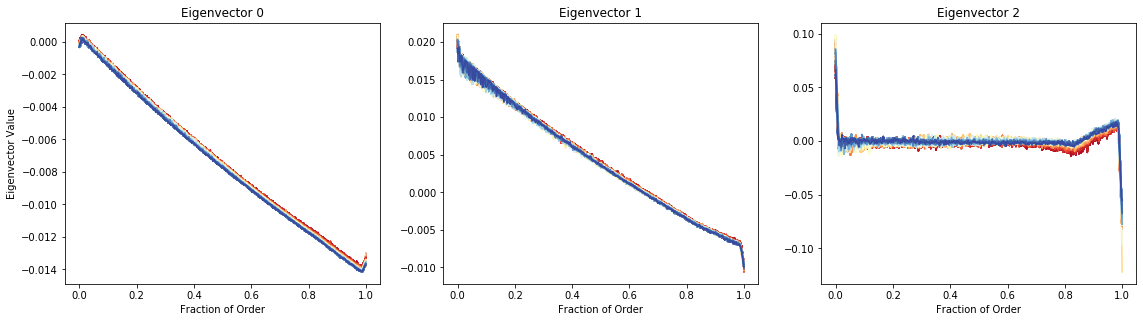

In [18]:
plt.figure(figsize=(6.4*3,4.8))
plt.subplot(131)
plt.plot(iter_x_values[:,bad_mask][:,0],'.-')
plt.xlim(0,10)
plt.subplot(132)
plt.plot(iter_x_values[:,bad_mask][:,50],'.-')
plt.xlim(0,10)
plt.subplot(133)
plt.plot(iter_x_values[:,bad_mask][:,100],'.-')
plt.xlim(0,10)

plt.figure(figsize=(6.4*3,4.8))
ax1 = plt.subplot(131)
plt.title('Eigenvector 0')
plt.ylabel('Eigenvector Value')
plt.xlabel('Fraction of Order')
ax2 = plt.subplot(132)
plt.title('Eigenvector 1')
plt.xlabel('Fraction of Order')
ax3 = plt.subplot(133)
plt.title('Eigenvector 2')
plt.xlabel('Fraction of Order')
colors = sns.color_palette("RdYlBu",len(order_list))
for i in range(num_iters):
    for j, nord in enumerate(order_list):
        ax1.plot(np.linspace(0,1,np.sum(orders==nord)),
                 iter_vvs[i][0][orders==nord],color=colors[j])
        ax2.plot(np.linspace(0,1,np.sum(orders==nord)),
                 iter_vvs[i][1][orders==nord],color=colors[j])
        ax3.plot(np.linspace(0,1,np.sum(orders==nord)),
                 iter_vvs[i][2][orders==nord],color=colors[j])
plt.savefig('./Figures/191120_eigenVs.png')

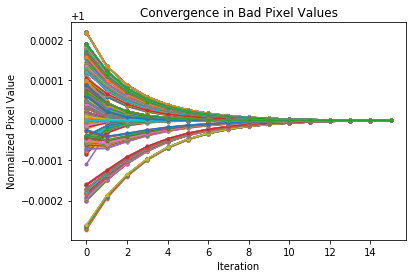

In [19]:
plt.figure()
plt.title('Convergence in Bad Pixel Values')
plt.ylabel('Normalized Pixel Value')
plt.xlabel('Iteration')
plt.plot(iter_x_values[:,bad_mask]/iter_x_values[-1,bad_mask],'.-');
plt.savefig('./Figures/191120_badPixConvergence.png')

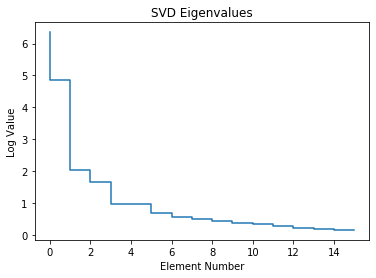

In [20]:
plt.figure()
plt.title('SVD Eigenvalues')
plt.xlabel('Element Number')
plt.ylabel('Log Value')
plt.step(np.arange(16),np.log(ss[:16]))
plt.savefig('./Figures/191120_ssStep.png')